In [6]:
import sys

sys.path.append('/Users/valuamba/projs/components_agent_sales/app/utils')
sys.path.append('/Users/valuamba/projs/components_agent_sales/app/core/clients/')

from html_messages_parser import get_element_messages, get_messages_from_html_file, select_json_block 
from famaga import FamagaClient

In [249]:
import pandas as pd

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

In [95]:
import warnings
from importlib import reload

warnings.filterwarnings('ignore')

In [28]:
from pathlib import Path
import hashlib
import subprocess
import json
from bs4 import BeautifulSoup


text_cache = Path('cache')

def sha1(input_string):
    """Helper to hash input strings"""
    try:

        # Step 5: Create a new SHA-1 hash object
        hash_object = hashlib.sha1()

        # Step 6: Update the hash object with the bytes-like object
        hash_object.update(input_string.encode('utf-8'))

        # Step 7: Get the hexadecimal representation of the hash
        return hash_object.hexdigest()
    except Exception as e:
        raise ValueError(input_string) from e


from functools import wraps
import inspect
import json
import pandas as pd
import hashlib


class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_dict'):
            return obj.to_dict()
        if isinstance(obj, pd.Int64Dtype):
            return int(obj)  # Convert Int64 to a regular int
        return json.JSONEncoder.default(self, obj)


def stored(func):
    """
    implements nix-like durable memoisation of function results.

    Lazy way to avoid recomputing expensive calls. Expects results to be JSON-serializable
    """
    @wraps(func)
    def CACHE(*args, **kwargs):
        name = func.__name__
        meta = {}

        meta["name"] = name
        meta["func"] = inspect.getsource(func)
        meta["args"] = args
        meta["kwargs"] = kwargs

        js = json.dumps(meta, cls=CustomEncoder)  # Using CustomEncoder
        sha = hashlib.sha1(js.encode('utf-8'))

        digest = sha.hexdigest()

        path = text_cache / f"{digest}-{name}.json"

        if path.exists():
            with path.open('r') as r:
                cached = json.load(r)
            return cached["result"]
        result = func(*args, **kwargs)
        meta["result"] = result
        with path.open('w') as w:
            json.dump(meta, w, cls=CustomEncoder)  # Using CustomEncoder
        return result

    return CACHE

In [29]:
from functools import wraps
import inspect
import json
import pandas as pd
import hashlib


class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj, 'to_dict'):
            return obj.to_dict()
        if isinstance(obj, pd.Int64Dtype):
            return int(obj)  # Convert Int64 to a regular int
        return json.JSONEncoder.default(self, obj)


def stored(func):
    """
    implements nix-like durable memoisation of function results.

    Lazy way to avoid recomputing expensive calls. Expects results to be JSON-serializable
    """
    @wraps(func)
    def CACHE(*args, **kwargs):
        name = func.__name__
        meta = {}

        meta["name"] = name
        meta["func"] = inspect.getsource(func)
        meta["args"] = args
        meta["kwargs"] = kwargs

        js = json.dumps(meta, cls=CustomEncoder)  # Using CustomEncoder
        sha = hashlib.sha1(js.encode('utf-8'))

        digest = sha.hexdigest()

        path = text_cache / f"{digest}-{name}.json"

        if path.exists():
            with path.open('r') as r:
                cached = json.load(r)
            return cached["result"]
        result = func(*args, **kwargs)
        meta["result"] = result
        with path.open('w') as w:
            json.dump(meta, w, cls=CustomEncoder)  # Using CustomEncoder
        return result

    return CACHE

In [24]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
openai_client = OpenAI()

@stored
def get_gpt(content, model="gpt-4-1106-preview", temperature=0, max_tokens=1000, stream=True):
    """
    Cached call to GPT.
    """
    messages = [{"role": "user", "content": content}]

    if stream:
        response = openai_client.chat.completions.create(
            model=model, 
            messages=messages, 
            temperature=temperature, 
            stream=True
        )
        
        collected_messages = []
        for chunk in response:
            if chunk.choices[0].delta.content:
                print(chunk.choices[0].delta.content, end='')
                collected_messages.append(chunk.choices[0].delta.content)
    
        content_str = ''.join(collected_messages)
        return content_str
    else:
        completion = openai_client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens,
        )
        return completion.model_dump()


In [53]:
import requests
import logging
import pandas as pd
from typing import Dict, Any


BASE_URL = "https://api.famaga.org"


class APIClientV2:
    def __init__(self, token: str) -> None:
        self.token = token

    def _get_headers(self) -> Dict[str, str]:
        return {"Authorization": f"Bearer {self.token}"}

    def _handle_response(self, response: requests.Response) -> Dict:
        try:
            response.raise_for_status()
            print(f"Request to {response.url} succeeded with status code {response.status_code}")
            return response.json()
        except requests.exceptions.HTTPError as e:
            print(f"HTTP error occurred: {e}")
            raise
        except requests.exceptions.RequestException as e:
            print(f"Error occurred: {e}")
            raise

    @stored
    def _get(self, endpoint: str, params: Dict = None, limit: int = 100, page: int = 1) -> Dict:
        url = f"{BASE_URL}{endpoint}"
        if params is None:
            params = {}
        params['limit'] = limit
        params['page'] = page
        response = requests.get(url, headers=self._get_headers(), params=params)
        return self._handle_response(response)

    def _flatten_json(self, y: Dict[str, Any], parent_key: str = '', sep: str = '_') -> Dict[str, Any]:
        items = []
        for k, v in y.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.extend(self._flatten_json(v, new_key, sep=sep).items())
            elif isinstance(v, list):
                for i, item in enumerate(v):
                    items.extend(self._flatten_json({f"{new_key}_{i}": item}).items())
            else:
                items.append((new_key, v))
        return dict(items)

    def offers_by_client_id(self, client_id: int, limit: int = 100, page: int = 1) -> pd.DataFrame:
        data = self._get('/requisition', params={'client': client_id}, limit=limit, page=page)
        flattened_data = [self._flatten_json(content) for content in data["content"]]
        return pd.DataFrame(flattened_data)

    def offers_by_deal_id(self, deal_id: int, limit: int = 100, page: int = 1) -> pd.DataFrame:
        data = self._get('/requisition', params={'request': deal_id}, limit=limit, page=page)
        flattened_data = [self._flatten_json(content) for content in data["content"]]
        return pd.DataFrame(flattened_data)

    def get_deals(self, limit: int = 100, page: int = 1) -> pd.DataFrame:
        data = self._get('/requisition', params=None, limit=limit, page=page)
        flattened_data = [self._flatten_json(content) for content in data["content"]]
        return pd.DataFrame(flattened_data)

    def offer_products(self, offer_id: int, limit: int = 100, page: int = 1) -> pd.DataFrame:
        data = self._get(f'/requisition/{offer_id}/products', limit=limit, page=page)
        flattened_data = [self._flatten_json(product) for product in data]
        return pd.DataFrame(flattened_data)

    def get_notice_mail(self, request_id: int, limit: int = 100, page: int = 1) -> pd.DataFrame:
        data = self._get('/requisition-client-history', params={'request': request_id}, limit=limit, page=page)
        flattened_data = [self._flatten_json(content) for content in data["content"]]
        return pd.DataFrame(flattened_data)

    def _calculations_to_df(self, data):
        product_data = []
        
        for entry in data["content"]:
            if entry["version_data"]:
                calculation_id = entry["id"]
                request_id = entry["request"]["id"]
                created_at = entry["created_at"]

                for product in entry["version_data"]["products"]:
                    if isinstance(product, dict):
                        product_entry = {
                            "request_id": request_id,
                            "calculation_id": calculation_id,
                            "created_at": created_at,
                            **product
                        }
                        product_data.append(product_entry)

        product_df = pd.DataFrame(product_data)
        return product_df
        
    
    def get_calculation_history(self, request_id: int, limit: int = 100, page: int = 1) -> pd.DataFrame:
        data = self._get('/calculation-history', params={'request': request_id}, limit=limit, page=page)
        return self._calculations_to_df(data)

    def get_calculations(self, limit: int = 100, page: int = 1) -> pd.DataFrame:
        data = self._get('/calculation-history', params=None, limit=limit, page=page)
        return self._calculations_to_df(data)

    def to_dict(self):
        return {
            "token": self.token
        }

In [54]:
client = APIClientV2('YXBpZmFtYWdhcnU6RHpJVFd1Lk1COUV4LjNmdERsZ01YYlcvb0VFcW9NLw')


In [36]:
deals_df = client.get_deals(limit=10000, page=2)

Request to https://api.famaga.org/requisition?limit=10000&page=2 succeeded with status code 200


In [435]:
calculations_df = client.get_calculations(limit=5000, page=1)

In [436]:
calculations_df

,request_id,calculation_id,created_at,id,tax,unit,count,weight,articul,expense,brand_id,discount,margin_ru,description,price_deliv,model_number,price_buy_de,price_buy_ru,price_sell_ru,description_de,cc_id,price,ri_id,state,ordering,price_buy,price_end,articul_id,created_by,price_sell,brand_title,checked_out,contractor_id,discount_client,checked_out_time,confirmed_arrival_to,confirmed_arrival_from,planned_arrival_germany_to,planned_arrival_germany_from
0,513767,3040067,2024-06-03T15:18:15+00:00,1289677,7,set,1,10,10J162,0,7304,0,28,"Steel,Tool Box,24 in \nCountry of Origin: Chin...",0,,0,198.57,658.43,"Steel,Tool Box,24 in \nCountry of Origin: Chin...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,513767,3040066,2024-06-03T15:17:38+00:00,1289677,7,set,1,10,10J162,0,7304,0,25,"Steel,Tool Box,24 in \nCountry of Origin: Chin...",0,,0,198.57,640.17,"Steel,Tool Box,24 in \nCountry of Origin: Chin...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,514169,3040064,2024-06-03T15:15:55+00:00,1289715,7,pcs,1,13,0821401133 RD 80/100,0,8182,0,15,"Feststelleinheit, Serie LU1",0,,0,814.55,977.12,"Feststelleinheit, Serie LU1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,514169,3040063,2024-06-03T15:15:39+00:00,1289715,7,pcs,1,13,0821401133 RD 80/100,0,8182,0,15,"Feststelleinheit, Serie LU1",0,,0,814.55,977.12,"Feststelleinheit, Serie LU1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,514441,3040062,2024-06-03T15:13:43+00:00,1289713,7,pcs,1,1,4V21008BG,0,891,0,22,Valve,0,,0,8.15,11.68,Valve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7577,512786,3035073,2024-05-30T09:12:48+00:00,1287768,7,pcs,4,0.5,K32S.C6E,0,13238,0,16,Seal,0,,0,63,128.57,seal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7578,512786,3035072,2024-05-30T09:12:07+00:00,1287768,7,pcs,4,0.5,K32S.C6E,0,13238,0,16,Seal,0,,0,63,128.57,seal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7579,512786,3035071,2024-05-30T09:12:02+00:00,1287768,7,pcs,4,0.5,K32S.C6E,0,13238,0,16,Seal,0,,0,63,128.57,seal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7580,501928,3035069,2024-05-30T09:11:20+00:00,1287775,7,pcs,6,1,PMX-24,0,8114,0,22,WAYCON PMX-24\nWarennummer: 90292038\nUrsprung...,0,,0,159,208.12,WAYCON PMX-24\nWarennummer: 90292038\nUrsprung...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [438]:
calculations_df.unit.unique()

AttributeError: 'DataFrame' object has no attribute 'maring_ru'

(array([6.923e+03, 3.000e+02, 1.350e+02, 1.150e+02, 2.600e+01, 3.000e+01,
        2.100e+01, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.300e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00]),
 array([ -179.85  ,  2006.1105,  4192.071 ,  6378.0315,  8563.992 ,
        10749.9525, 12935.913 , 15121.8735, 17307.834 , 19493.7945,
        21679.755 , 23865.7155, 26051.676 , 28237.6365, 30423.597 ,
        32609.5575, 34795.518 , 36981.4785, 39167.439 , 41353.3995,
        43539.36  ]),
 <BarContainer object of 20 artists>)

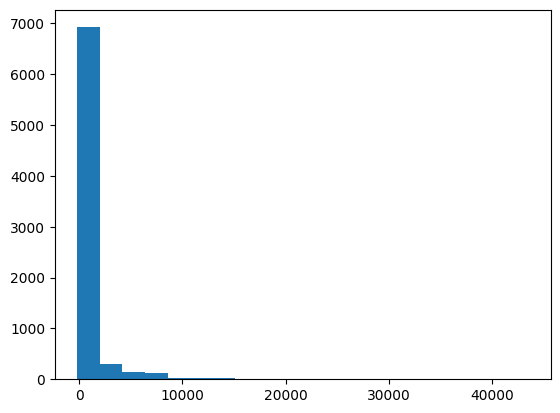

In [457]:
import matplotlib.pyplot as plt

calculations_df['price_sell_ru'] = calculations_df.price_sell_ru.astype(float)

plt.hist(calculations_df.price_sell_ru.dropna(), bins=20)
# plt.xticks(calculations_df.price_sell_ru[::100])

In [493]:
np.quantile(calculations_df.price_sell_ru.dropna(), 0.1),

(0.0,)

In [484]:
sorted(calculations_df.price_sell_ru)[6530:6540]

[6439.32, 6439.32, 6439.32, 6439.32, 6439.32, nan, 0.0, 0.0, 0.0, 0.0]

In [454]:
calculations_df.price_sell_ru.describe()

count     7575.000000
mean       788.411721
std       2468.458104
min       -179.850000
25%         23.440000
50%        121.130000
75%        480.900000
max      43539.360000
Name: price_sell_ru, dtype: float64

In [43]:
sorted(deals_df['decision'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]

In [ ]:
## import pandas as pd
import json


client_id = 111636
# Step 1: Get unique request_id from client_purchase_history_df
client_purchase_history_df = client.offers_by_client_id(client_id)
unique_request_ids = client_purchase_history_df['request_id'].unique()

# Step 2: Build common DataFrame from request_ids with offer_products
offer_products_list = []
for request_id in unique_request_ids:
    offer_products_df = client.offer_products(request_id)
    offer_products_df['request_id'] = request_id  # Add request_id to each row
    offer_products_list.append(offer_products_df)
common_offer_products_df = pd.concat(offer_products_list, ignore_index=True)

# Step 3: Build common DataFrame from request_ids with get_notice_mail
notice_mail_list = []
for request_id in unique_request_ids:
    notice_mail_df = client.get_notice_mail(int(request_id))
    notice_mail_df['request_id'] = request_id  # Add request_id to each row
    notice_mail_list.append(notice_mail_df)
common_notice_mail_df = pd.concat(notice_mail_list, ignore_index=True)

# Step 4: Build common DataFrame from request_ids with get_calculation_history
calculation_history_list = []
for request_id in unique_request_ids:
    print(request_id)
    calculation_history_df = client.get_calculation_history(int(request_id))
    calculation_history_df['request_id'] = request_id  # Add request_id to each row
    calculation_history_list.append(calculation_history_df)
common_calculation_history_df = pd.concat(calculation_history_list, ignore_index=True)

In [ ]:
df = pd.DataFrame(data)

# Ensure created_at is a datetime column
df['created_at'] = pd.to_datetime(df['created_at'])

# Sort the DataFrame by created_at (date) in descending order and then by calculation_id in descending order
df = df.sort_values(by=['created_at', 'calculation_id'], ascending=[False, False])

def df_to_string(df):
    result = ""
    for request_id, req_group in df.groupby('request_id'):
        result += f"Deal {request_id}\n\n"
        for calculation_id, calc_group in req_group.groupby('calculation_id'):
            result += f"Calculation: {calc_group.iloc[0]['id']}\n"
            for _, row in calc_group.iterrows():
                result += f"{row['articul']} - {row['price_sell_ru']}\n"
            result += "\n"
    return result

result_string = df_to_string(df)
print(result_string)

In [314]:
class DecisionType:
    NO_DECISION = 0
    BILLED = 1
    BILL_PAID = 2
    PRICE = 3
    DELIVERY_TIME = 4
    REJECT_OTHER_REASON = 5
    TENDER = 6
    COLLECTING_OTHER_KP = 7
    THINK_OTHER_REASON = 8
    CONTRACT_SIGNING = 9
    OTHER_AGREEMENT = 10

YES_DECISIONS = [DecisionType.BILLED, DecisionType.BILL_PAID]
NO_DECISIONS = [DecisionType.PRICE, DecisionType.DELIVERY_TIME, DecisionType.REJECT_OTHER_REASON]
THINK_DECISIONS = [DecisionType.TENDER, DecisionType.COLLECTING_OTHER_KP, DecisionType.THINK_OTHER_REASON]
COORDINATION_DECISIONS = [DecisionType.CONTRACT_SIGNING, DecisionType.OTHER_AGREEMENT]

In [50]:
BLOCKED_FIRMS = [88704]

In [51]:
deals_df = deals_df[~deals_df['request_firm_id'].isin(BLOCKED_FIRMS)]


deals_df[deals_df['decision'].isin(YES_DECISIONS)]

,id,request_id,request_firm_id,request_firm_title,request_firm_type,request_firm_conversion,request_firm_link,request_initials,request_brand_id,request_brand_title,...,created,lastsend,processing_time,decision,link,target_price,target_price_solved,state,proform_fam,request_curator
3,373770,498091,124668,PMT-SYSTEMS,2,,index.php?option=com_oscrm&view=firmform&id=12...,KP,6222,BORRIES Markier-Systeme,...,2024-04-15T12:34:46+00:00,2024-04-15T12:53:02+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
4,373769,499139,84605,AGROAD s. r. o.,2,,index.php?option=com_oscrm&view=firmform&id=84...,EG,7639,BLOKSMA Engineering,...,2024-04-15T12:33:38+00:00,2024-04-15T12:53:05+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
15,373758,498023,124657,UAB PORIX,2,,index.php?option=com_oscrm&view=firmform&id=12...,KP,257,SOUTHCO,...,2024-04-15T12:03:33+00:00,2024-04-15T12:37:33+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
20,373753,498775,118172,PPHU IMEX,1,,index.php?option=com_oscrm&view=firmform&id=11...,KP,9706,EMILE MAURIN,...,2024-04-15T11:50:56+00:00,2024-04-15T11:52:48+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
24,373749,499135,89791,PANTATEC INDUSTRIAL Trading LLC,2,,index.php?option=com_oscrm&view=firmform&id=89...,EG,11661,ZD-MOTOR,...,2024-04-15T11:42:40+00:00,2024-04-15T11:54:34+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,363789,483981,67242,ADNOC,2,,index.php?option=com_oscrm&view=firmform&id=67...,EG,3652,AI-TEK Instruments,...,2024-02-26T08:31:41+00:00,2024-02-26T08:37:05+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
9984,363787,484058,122150,AMG Marek Górny sp.j.,1,,index.php?option=com_oscrm&view=firmform&id=12...,AKA,6795,WISTRO,...,2024-02-26T08:29:24+00:00,2024-02-26T08:42:34+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
9986,363785,468267,119017,APEXX SRL,1,,index.php?option=com_oscrm&view=firmform&id=11...,AKA,15999,Tecflam,...,2024-02-26T08:24:31+00:00,2024-03-06T12:59:21+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN
9990,363781,484076,29450,SilkRoad24 GmbH,3,7.14,index.php?option=com_oscrm&view=firmform&id=29...,AKA,8188,Polylux,...,2024-02-26T08:16:12+00:00,2024-02-26T08:20:18+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0.0,False,True,NaN,NaN


In [63]:
calculations_df['price_end'] = pd.to_numeric(calculations_df['price_end'], errors='coerce')
calculations_df['price_sell_ru'] = pd.to_numeric(calculations_df['price_sell_ru'], errors='coerce')

In [356]:
import numpy as np


def get_final_calculation_price(calculations_df):
    df = calculations_df.copy()

    df['price_end'] = pd.to_numeric(df['price_end'], errors='coerce')
    df['price_sell_ru'] = pd.to_numeric(df['price_sell_ru'], errors='coerce')

    df['price_final'] = np.where((df['price_end'].isna()) | (df['price_end'] == 0) | (df['price_end'] == 0.00), 
        df['price_sell_ru'], df['price_end'])

    return df

In [423]:
calculations_df.loc[130:]

,request_id,calculation_id,created_at,id,tax,unit,count,weight,articul,expense,brand_id,discount,margin_ru,description,price_deliv,model_number,price_buy_de,price_buy_ru,price_sell_ru,description_de,cc_id,price,ri_id,state,ordering,price_buy,price_end,articul_id,created_by,price_sell,brand_title,checked_out,contractor_id,discount_client,checked_out_time,confirmed_arrival_to,confirmed_arrival_from,planned_arrival_germany_to,planned_arrival_germany_from,price_final
130,513654,3039986,2024-06-03T14:39:47+00:00,1289641,7,pcs,20,0.238,2646566,0,2153,0,22,NIED Verbinder KSV60S,0,,0,2.48,3.33,NIED Verbinder KSV60S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.33
131,513654,3039986,2024-06-03T14:39:47+00:00,1289643,7,pcs,100,0.801,2305229,0,2153,0,22,NIED WANDBEFEST.-KLAMMER WWS10\nSonderbeschaff...,0,,0,8.35,11.22,NIED WANDBEFEST.-KLAMMER WWS10\nSonderbeschaff...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.22
132,513654,3039986,2024-06-03T14:39:47+00:00,1289644,7,pcs,21,12.18,2646453,0,2153,0,22,NIED Steigetrassen STM60.603/3\nSonderbeschaff...,0,,0,126.95,170.57,NIED Steigetrassen STM60.603/3\nSonderbeschaff...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.57
133,513654,3039986,2024-06-03T14:39:47+00:00,1289645,7,pcs,54,2.608,2851632,0,2153,0,22,NIED Steigetrasse STM60.203/3\nSonderbeschaffu...,0,,0,27.18,36.52,NIED Steigetrasse STM60.203/3\nSonderbeschaffu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.52
134,513654,3039986,2024-06-03T14:39:47+00:00,1289646,7,pack,1,8.988,2634002,0,2153,0,22,NIED BÜGELSCHELLEN BK22\n\n100 ST in pack,0,,0,93.68,125.87,NIED BÜGELSCHELLEN BK22\n\n100 ST in pack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7577,512786,3035073,2024-05-30T09:12:48+00:00,1287768,7,pcs,4,0.5,K32S.C6E,0,13238,0,16,Seal,0,,0,63,128.57,seal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.57
7578,512786,3035072,2024-05-30T09:12:07+00:00,1287768,7,pcs,4,0.5,K32S.C6E,0,13238,0,16,Seal,0,,0,63,128.57,seal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.57
7579,512786,3035071,2024-05-30T09:12:02+00:00,1287768,7,pcs,4,0.5,K32S.C6E,0,13238,0,16,Seal,0,,0,63,128.57,seal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.57
7580,501928,3035069,2024-05-30T09:11:20+00:00,1287775,7,pcs,6,1,PMX-24,0,8114,0,22,WAYCON PMX-24\nWarennummer: 90292038\nUrsprung...,0,,0,159,208.12,WAYCON PMX-24\nWarennummer: 90292038\nUrsprung...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.12


In [207]:
deals_df[deals_df['request_id'] == 507295]

,id,request_id,request_firm_id,request_firm_title,request_firm_type,request_firm_conversion,request_firm_link,request_initials,request_brand_id,request_brand_title,...,created,lastsend,processing_time,decision,link,target_price,target_price_solved,state,proform_fam,request_curator


In [251]:
current_deal.head(1)

,id,request_id,request_firm_id,request_firm_title,request_firm_type,request_firm_conversion,request_firm_link,request_initials,request_brand_id,request_brand_title,request_brand_conversion,request_brand_link,request_contractor_id,request_contractor_title,request_contractor_link,request_contractor_created,request_contractor_modified,request_curator_id,request_curator_name,request_curator_username,request_curator_email,request_cost,created,lastsend,processing_time,decision,link,target_price,target_price_solved,state,proform_fam
0,382392,506694,35530,"UNIVERSAL SUPPLIES AND SERVICES,INC",3,5.36,index.php?option=com_oscrm&view=firmform&id=35...,EG,2991,Leser,5.36,index.php?option=com_oscrm&view=brandform&id=2...,1079,LESER GmbH & Co. KG,index.php?option=com_oscrm&view=contractorform...,2013-12-30T12:48:30+00:00,2023-08-15T09:17:00+00:00,907,Salome Barateli,Salome Barateli,slb@famaga.de,14342.23,2024-05-28T08:33:28+00:00,2024-05-28T12:40:38+00:00,,0,index.php?option=com_oscrm&view=requisition&re...,0,False,True,None


In [250]:
customer_calculations.head(1)

,request_id,calculation_id,created_at,id,tax,unit,count,weight,articul,expense,brand_id,discount,margin_ru,description,price_deliv,model_number,price_buy_de,price_buy_ru,price_sell_ru,description_de,cc_id,price,ri_id,state,ordering,price_buy,price_end,articul_id,created_by,price_sell,brand_title,checked_out,contractor_id,discount_client,checked_out_time,confirmed_arrival_to,confirmed_arrival_from,planned_arrival_germany_to,planned_arrival_germany_from
0,507295,3039998,2024-06-03T14:42:16+00:00,1289126,7,pcs,9,0.006,500.2407.0000,0,2991,0,19,Gasket T459,0,,0,7,10.29,Gasket T459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [427]:
deal_id = 502469
current_deal = client.offers_by_deal_id(deal_id)
current_deal_products = client.offer_products(deal_id)

client_id = int(current_deal.loc[0]['request_firm_id'])

all_customer_offers = client.offers_by_client_id(client_id)

# exclude current deal_id
customer_offers = all_customer_offers[~(all_customer_offers['request_id'] == deal_id)]
customer_offers = customer_offers[customer_offers['decision'].isin(YES_DECISIONS)]

purchase_history_str = ''
unique_request_ids = customer_offers['request_id'].unique()

if len(unique_request_ids) > 0:
    customer_products_df = get_products_history(unique_request_ids)
    customer_calculations = get_calculations(unique_request_ids)
    
    discounted_deals = get_discounted_deals(unique_request_ids)
    
    bought_earlier_products_df = customer_products_df[
        customer_products_df['articul'].isin(current_deal_products['articul'])
    ]
    
    purchase_history_dict = get_requests_dict(bought_earlier_products_df, discounted_deals)
    
    purchase_history_str = prettify_deal(customer_offers, customer_calculations, purchase_history_dict, customer_products_df)


current_deal_dict = get_requests_dict(get_products_history(current_deal['request_id']), pd.DataFrame())
current_deal_str = prettify_deal(current_deal, customer_calculations, current_deal_dict, current_deal_products)


customer_data = {
    'desired_discount_per': None,
    'desired_price': None,
    'is_specified_desired_price': False,
    'is_customer_large_company': False,
    'deals_without_purchase': all_customer_offers[~(all_customer_offers['decision'].isin(YES_DECISIONS))].drop_duplicates().shape[0],
    'deals_with_purchases': all_customer_offers[(all_customer_offers['decision'].isin(YES_DECISIONS))].drop_duplicates().shape[0]   
}

Request to https://api.famaga.org/requisition?request=502469&limit=100&page=1 succeeded with status code 200
Request to https://api.famaga.org/requisition/502469/products?limit=100&page=1 succeeded with status code 200
Request to https://api.famaga.org/requisition?client=118831&limit=100&page=1 succeeded with status code 200


In [ ]:
client.get_calculation_history(int(502224))

In [400]:
customer_products_df = get_final_calculation_price(customer_products_df)

customer_products_df[['count', 'price', 'price_buy_de', 'price_buy_ru', 'price_final']]

# customer_products_df

,count,price,price_buy_de,price_buy_ru,price_final
0,1,715,0,715.00,887.81
1,1,35,0,35.00,70.80
2,1,47.93,0,47.93,47.93
3,1,264,0,264.00,344.50
4,1,85,0,85.00,102.00
5,1,22.33,0,22.33,22.33


In [374]:
current_deal_products

,id,ri_id,cc_id,request_id,brand_id,articul,articul_id,model_number,description,description_de,contractor_id,count,price,price_buy_de,price_end,price_deliv,discount,discount_client,margin_ru,tax,price_buy_ru,price_buy,price_sell_ru,price_sell,unit,weight,planned_arrival_germany_from,planned_arrival_germany_to,confirmed_arrival_from,confirmed_arrival_to,checked_out,checked_out_time,created_by,state,ordering,brand_title
0,1265570,945882,586552,502224,6512,0410-0050-03,735911,,Fenster: 2-Saphir Typ A\n- Material: Saphir\n-...,Fenster: 2-Saphir Typ A\n- Material: Saphir\n-...,3267,3,692,0,893.59,0,0,0,22,7,692,0,893.59,0,pcs,3.333,0,0,0,0,0,0000-00-00 00:00:00,0,1,1109155,optek-Danulat


In [332]:
unique_request_ids

array([], dtype=int64)

In [428]:
print(prettify_customer_data(customer_data) + '\n')
print(current_deal_str)
print(purchase_history_str)

Desired Discount Percentage: Not specified
Desired Price: Not specified
Is Specified Desired Price: No
Is Customer Large Company: No
Deals Without Purchase: 1
Deals With Purchases: 0

Deal #502469 2024-05-02:

Products:
(D7M-LF3) 4946 3 qty., 83.04€ (margin 22%)


---




In [426]:
decision_resp = get_discount_decision(current_deal_str, purchase_history_str, prettify_customer_data(customer_data))

2024-06-04 01:58:42,802 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Based on the provided instruction and customer data, here is the decision-making process:

1. **Customer has NEVER purchased before and has NOT specified a desired price:**
   
   - **Deals Without Purchase:** 100
   - **Deals With Purchases:** 0

Given that the customer has more than 10 quotations without any sales, we should set a 10% margin. This customer is a candidate for the blacklist; if they do not buy even with the maximum discount, we will likely not work with them in the future.

### Current Deal Analysis

- **Current Margin:** 16%
- **Required Margin:** 10%

### Calculation

1. **Total Purchase Price:** 4 qty. * 134.53€ = 538.12€
2. **Desired Margin:** 10%

Using the margin formula:
\[ \text{Total Selling Price} = \frac{\text{Total Purchase Price}}{1 - \frac{\text{Desired Margin}}{100}} \]

\[ \text{Total Selling Price} = \frac{538.12}{1 - 0.10} \]

\[ \text{Total Selling Price} = \frac{538.12}{0.90} \]

\[ \text{Total Selling Price} = 597.91€ \]

### Decision

- **Offer Pr

In [297]:
purchase_history_dict = get_requests_dict(bought_earlier_products_df, discounted_deals)

purchase_history_str = prettify_deal(customer_offers, customer_calculations, purchase_history_dict, customer_products_df)
print(purchase_history_str)

Deal #507295 2024-06-03:

Calculations:
2024-06-03 14:42:16+00:00 3039998 (200.2039.9000) 158.8
2024-06-03 08:55:15+00:00 3038572 (200.2039.9000) 160.49
2024-06-03 14:42:16+00:00 3039998 (200.2149.9000) 158.8
2024-06-03 08:55:15+00:00 3038572 (200.2149.9000) 160.49
2024-06-03 14:42:16+00:00 3039998 (200.9949.9093) 433.77
2024-06-03 08:55:15+00:00 3038572 (200.9949.9093) 438.37
2024-06-03 14:42:16+00:00 3039998 (500.0407.0000) 10.29
2024-06-03 08:55:15+00:00 3038572 (500.0407.0000) 10.4
2024-06-03 14:42:16+00:00 3039998 (500.2407.0000) 10.29
2024-06-03 08:55:15+00:00 3038572 (500.2407.0000) 10.4
2024-06-03 14:42:16+00:00 3039998 (500.4205.0000) 63.23
2024-06-03 08:55:15+00:00 3038572 (500.4205.0000) 63.9
2024-06-03 14:42:16+00:00 3039998 (5012.1101) 77.93
2024-06-03 08:55:15+00:00 3038572 (5012.1101) 78.76
2024-06-03 14:42:16+00:00 3039998 (5012.1231) 176.45
2024-06-03 08:55:15+00:00 3038572 (5012.1231) 178.32

---



In [363]:
current_deal_dict = get_requests_dict(get_products_history(current_deal['request_id']), pd.DataFrame())

current_deal_str = prettify_deal(current_deal, customer_calculations, current_deal_dict, current_deal_products)
print(current_deal_str)

Deal #502224 2024-04-23:

Products:
(0410-0050-03) 6512 qty. 3 893.59€ ()


---



In [372]:
decision_resp = get_discount_decision(current_deal_str, purchase_history_str)

2024-06-04 01:23:58,084 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Based on the provided instruction and the customer data, here is the decision-making process:

1. **Customer has NOT previously purchased THIS product but specified a desired price:**
   - The customer has specified a desired price of 800€.
   - The product price is 893.59€.
   - We need to check if offering a discount to meet the desired price is feasible within the margin.

Let's calculate the margin if we offer the desired price:

\[ \text{Desired Price} = 800€ \]
\[ \text{Current Price} = 893.59€ \]
\[ \text{Discount} = 893.59€ - 800€ = 93.59€ \]
\[ \text{Discount Percentage} = \left( \frac{93.59€}{893.59€} \right) \times 100 \approx 10.47\% \]

Since the discount percentage (10.47%) is within the 10% margin allowed by the instruction, we can offer the desired price.

**Decision:**
- Offer the product at the desired price of 800€.
- Explain that this is the maximum possible discount.

**Communication to the customer:**

---

Dear Customer,

Thank you for your interest in our produc

In [ ]:
customer_products_df[customer_products_df['request_id'] == current_deal.loc[0]['request_id']]

get_products_history(current_deal['request_id'])

In [ ]:
## Test mocked purchased products

customer_products_df.groupby(by='articul').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [420]:
def prettify_customer_data(customer_data):
    # Update is_specified_desired_price based on desired_discount_per or desired_price
    if customer_data['desired_discount_per'] is not None or customer_data['desired_price'] is not None:
        customer_data['is_specified_desired_price'] = True
    else:
        customer_data['is_specified_desired_price'] = False

    # Prettify the data into a string
    prettified_data = [
        f"Desired Discount Percentage: {customer_data['desired_discount_per'] if customer_data['desired_discount_per'] is not None else 'Not specified'}",
        f"Desired Price: {customer_data['desired_price'] if customer_data['desired_price'] is not None else 'Not specified'}",
        f"Is Specified Desired Price: {'Yes' if customer_data['is_specified_desired_price'] else 'No'}",
        f"Is Customer Large Company: {'Yes' if customer_data['is_customer_large_company'] else 'No'}",
        f"Deals Without Purchase: {customer_data['deals_without_purchase']}",
        f"Deals With Purchases: {customer_data['deals_with_purchases']}"
    ]

    return '\n'.join(prettified_data)

In [378]:
def prettify_deal(deal_info_df, calculation_df, selected_deals, previously_bought_products_df):
    # Convert created_at to datetime for sorting
    calculation_df['created_at'] = pd.to_datetime(calculation_df['created_at'])

    previously_bought_products_df = get_final_calculation_price(previously_bought_products_df)
    
    # Initialize result string
    result_str = ""
    
    # Iterate over each request_id in selected_deals
    for request_id, deal_info in selected_deals.items():
        # Get deal information for the request_id
        if request_id in deal_info_df['request_id'].values:
            deal_info_row = deal_info_df[deal_info_df['request_id'] == request_id].iloc[0]
            deal_date = pd.to_datetime(deal_info_row['created']).date()
            
            # Format the deal info
            result_str += f"Deal #{request_id} {deal_date}:\n\n"
        
        # Add Products section
        if deal_info['products']:
            result_str += "Products:\n"
            for articul in deal_info['products']:
                product_row = previously_bought_products_df[previously_bought_products_df['articul'] == articul].iloc[0]
                brand_id = product_row['brand_id']
                result_str += f"({articul}) {brand_id} {product_row['count']} qty., {product_row['price_final']}€ (margin {product_row['margin_ru']}%)\n"
            result_str += "\n"

        # Filter calculations for the current request_id
        filtered_calculations = calculation_df[calculation_df['request_id'] == request_id]

        if len(deal_info['calculations_product']) > 0:
            result_str += "Calculations:\n"
            
            # Iterate over each product (articul) and its calculations
            for articul, calc_ids in deal_info['calculations_product'].items():
                # Filter calculations for the current articul and calculation IDs
                filtered_calcs = filtered_calculations[
                    (filtered_calculations['articul'] == articul) &
                    (filtered_calculations['calculation_id'].isin(calc_ids))
                ]
                
                # Sort calculations by created_at in descending order
                sorted_calcs = filtered_calcs.sort_values(by='created_at', ascending=False)
                
                # Format each calculation entry
                for _, calc_row in sorted_calcs.iterrows():
                    created_at = calc_row['created_at']
                    calculation_id = calc_row['calculation_id']
                    price = calc_row['price_end'] if pd.notna(calc_row['price_end']) else calc_row['price_sell_ru']
                    
                    result_str += f"{created_at} {calculation_id} ({articul}) {price}\n"
        
        result_str += "\n---\n"
    
    return result_str

In [279]:
def get_requests_dict(previously_bought_products, discounted_deals):
    # Initialize the result dictionary
    result_dict = {}

    if len(discounted_deals) > 0:
        # Group by 'request_id' for discounted deals
        grouped = discounted_deals.groupby('request_id')
        
        for request_id, group in grouped:
            # Initialize the inner structure
            request_dict = {
                "request_id": request_id,
                "products": [],
                "full_calculations": [],
                "calculations_product": {}
            }
        
            # Iterate through the rows of the group
            for idx, row in group.iterrows():
                articul = row['articul']
                calculations = [row['first_offer_calculation_id'], row['latest_offer_calculation_id']]
                
                if articul not in request_dict['calculations_product']:
                    request_dict['calculations_product'][articul] = []
                
                request_dict['calculations_product'][articul].extend(calculations)
                
                # To ensure uniqueness of calculations, you can use a set
                request_dict['calculations_product'][articul] = list(set(request_dict['calculations_product'][articul]))
        
            # Add the constructed dictionary to the result
            result_dict[request_id] = request_dict
    
    # Add previously bought products to the dictionary
    for _, row in previously_bought_products.iterrows():
        request_id = row['request_id']
        articul = row['articul']
    
        if request_id not in result_dict:
            result_dict[request_id] = {
                "request_id": request_id,
                "products": [],
                "full_calculations": [],
                "calculations_product": {}
            }
    
        if articul not in result_dict[request_id]['products']:
            result_dict[request_id]['products'].append(articul)

    return result_dict



{507295: {'request_id': 507295,
  'products': ['200.2039.9000'],
  'full_calculations': [],
  'calculations_product': {'200.2039.9000': [3038572, 3039998],
   '200.2149.9000': [3038572, 3039998],
   '200.9949.9093': [3038572, 3039998],
   '500.0407.0000': [3038572, 3039998],
   '500.2407.0000': [3038572, 3039998],
   '500.4205.0000': [3038572, 3039998],
   '5012.1101': [3038572, 3039998],
   '5012.1231': [3038572, 3039998]}},
 416402: {'request_id': 416402,
  'products': ['5012.1163'],
  'full_calculations': [],
  'calculations_product': {}},
 416856: {'request_id': 416856,
  'products': ['5012.1163'],
  'full_calculations': [],
  'calculations_product': {}}}

In [288]:
r = get_requests_dict(get_products_history(current_deal['request_id']), pd.DataFrame())

result = prettify_deal(current_deal, customer_calculations, r, current_deal_products)
print(result)

Deal #506694 2024-05-28:

Products:
5012.2151 2991


---



In [246]:
def get_discounted_deals(unique_request_ids):
    all_discounted_requests = pd.DataFrame()
    
    for request_id in unique_request_ids:    
        calc_deal_df = calculations_df[calculations_df['request_id'] == request_id]
    
        discounted_requests = get_disconted_requests(calc_deal_df)
    
        if len(discounted_requests) > 1:
            all_discounted_requests = pd.concat([all_discounted_requests, discounted_requests], ignore_index=True)
    return all_discounted_requests


def get_calculations(unique_request_ids):
    calculation_history_list = []
    for request_id in unique_request_ids:
        calculation_history_df = client.get_calculation_history(int(request_id))
        calculation_history_df['request_id'] = request_id  # Add request_id to each row
        calculation_history_list.append(calculation_history_df)
    common_calculation_history_df = pd.concat(calculation_history_list, ignore_index=True)
    return common_calculation_history_df

def get_products_history(unique_request_ids):
    offer_products_list = []
    for request_id in unique_request_ids:
        offer_products_df = client.offer_products(request_id)
        offer_products_df['request_id'] = request_id  # Add request_id to each row
        offer_products_list.append(offer_products_df)
    common_offer_products_df = pd.concat(offer_products_list, ignore_index=True)
    return common_offer_products_df


In [430]:

@dataclass
class Calculation:
    id: int
    price_final: float
    count: int
    articul: str


for 



def get_disconted_requests(request_calcs: pd.DataFrame) -> pd.DataFrame:
    calc_deal_df = get_final_calculation_price(request_calcs)
    
    calc_deal_df['created_at'] = pd.to_datetime(calc_deal_df['created_at'])
    calc_deal_df = calc_deal_df.sort_values(by='created_at', ascending=False)
    
    discounted_calculations = []
    
    for index, row in calc_deal_df.groupby('articul'):
        if len(row) > 1:
            latest_offer = row.iloc[0]
            first_offer = row.iloc[-1]
        
            if first_offer['calculation_id'] != latest_offer['calculation_id']\
                and first_offer['articul'] == latest_offer['articul']\
                and first_offer['count'] == latest_offer['count']\
                and first_offer['price_final'] > latest_offer['price_final']:

                assert latest_offer['created_at'] > first_offer['created_at']
                assert latest_offer['calculation_id'] > first_offer['calculation_id']
                
                discounted_calculations.append({
                    'request_id': latest_offer['request_id'],
                    'articul':  latest_offer['articul'],
                    'first_offer_calculation_id': first_offer['calculation_id'],
                    'latest_offer_calculation_id': latest_offer['calculation_id']
                })
                print(f'({latest_offer['articul']}) {latest_offer['calculation_id']}) {latest_offer['price_final']} - ({first_offer['articul']}) {first_offer['price_final']}')
    
    return pd.DataFrame(discounted_calculations)


In [434]:
discounted_calcs_df.dtypes

request_id     int64
articul       object
dtype: object

In [140]:
discounted_calcs_df

,request_id,articul
0,513733,52104486


In [429]:
calc_deal_df

,request_id,calculation_id,created_at,id,tax,unit,count,weight,articul,expense,brand_id,discount,margin_ru,description,price_deliv,model_number,price_buy_de,price_buy_ru,price_sell_ru,description_de,cc_id,price,ri_id,state,ordering,price_buy,price_end,articul_id,created_by,price_sell,brand_title,checked_out,contractor_id,discount_client,checked_out_time,confirmed_arrival_to,confirmed_arrival_from,planned_arrival_germany_to,planned_arrival_germany_from,price_final
7580,501928,3035069,2024-05-30T09:11:20+00:00,1287775,7,pcs,6,1,PMX-24,0,8114,0,22,WAYCON PMX-24\nWarennummer: 90292038\nUrsprung...,0,,0,159,208.12,WAYCON PMX-24\nWarennummer: 90292038\nUrsprung...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.12


In [ ]:
calc_deal_df.groupby('articul').first().reset_index()

In [ ]:
calculations_df[~calculations_df['price_sell'].isna()]

In [396]:

@stored
def get_discount_decision(current_deal_str, purchase_history_str, customer_data):
    res = get_gpt(f"""
Here is an instruction:

1. **Customer previously purchased THIS product:** Try to offer the same price as last time if profitability allows. If not, set a 12% margin and explain that the supplier's price has changed, and this is the maximum possible discount.

2. **Customer has NOT previously purchased THIS product but specified a desired price:** Offer a discount if the margin allows. Otherwise, set a 10% margin and explain that this is the maximum possible discount.

3. **Customer has NOT purchased THIS product and has NOT specified a desired price, BUT has purchased other products:**
   
   a) **If the margin was unchanged in previous deals** (the price in the initial offer equals the price in the final offer for the same quantity within one quotation): Refuse the discount.

   b) **If the margin changed in previous deals** (the price in the initial offer does not equal the price in the final offer for the same quantity within one quotation):
   
      - If the price in the final offer is higher: Ignore the case (this is due to the supplier's price increase while the customer was deciding).
      - If a discount was given previously: Offer a 2% discount.

4. **Customer has NEVER purchased before and has NOT specified a desired price:** Check the total number of customer deals.
   
   a) **First quotation for a large company:** Offer a 2% discount and ask for the desired price.
   
   b) **First quotation for a non-large company:** Refuse the discount.
   
   c) **More than 10 quotations without any sales:** Set a 10% margin. This customer is a candidate for the blacklist; if they do not buy even with the maximum discount, we will likely not work with them in the future.
   
   d) **Several quotations with request dates differing by +/- 2 days (likely one project):** Propose a discount if the customer buys multiple quotations at once. Do not specify the exact price but ask for the desired price and hand it over to the manager for manual processing.

Additionally, remember the outcomes:
   
   a) **In case of a FULL discount refusal:** If the customer still buys, continue to refuse discounts. If the customer does not buy, offer a 2% discount next time and ask for the desired price.
   
   b) **In case of offering a 2% discount:** If the customer buys, continue offering 2% where possible. If the customer does not buy, offer a 3% discount next time (if margin allows) and continue to find the "acceptable discount" from deal to deal.

Margin formula:
 \text{{Margin}} = 100 \times \left(1 - \frac{{\text{{Total Purchase Price}}{{\text{{Total Selling Price}}\right) 

# Customer data

{customer_data}

## Current deal

{current_deal_str}

## Purchase history

{purchase_history_str}

Please make decision

    """, 'gpt-4o'
    )
    return res

In [ ]:
- 